# Introduction <a class="anchor" id="intro-header"></a>
This notebook provides extensive search and information extraction functionality for risk factors related to Sars-CoV-2, Covid-19, including the extraction and generation of odds ratios, confidence intervals and relevant excerpts. It facilitates search queries using an Apache Lucene based search engine over an index compiled on the full text of publications in the Kaggle competition metadata. It performs table extraction from publications of interest, along with extensive text mining of unstructured text through a robust [GrapeNLP](https://github.com/GrapeNLP) grammar with fuzzy matching capabilities.

The indexed metadata is searched using the Lucene search engine to uncover papers of interest and a PubMed online service is queried to find tabular data related to cohort and epidemiological studies. [PubMed](https://www.ncbi.nlm.nih.gov/pubmed/) is a free search engine accessing primarily the MEDLINE database of references and abstracts on life sciences and biomedical topics. Tables are automatically downloaded and relevant information is extracted. Odds ratios and confidence intervals are computed, where the relevant data is available.

A powerful grammar engine, [GrapeNLP](https://github.com/GrapeNLP), is also used to rapidly and robustly search unstructured publication text, retrieving the various statistics related to the significance of numerous risk factors on the fatality and severity of Covid-19. Summary tables are generated and are exported as CSV files.

It has successfully generated numerous table entries for the following risk factors: 

* Hypertension
* Diabetes 
* Male gender 
* Heart Disease 
* COPD 
* Smoking Status 
* Age 
* Cerebrovascular disease 
* Cardio- and cerebrovascular disease 
* Cancer 
* Respiratory system diseases 
* Chronic kidney disease 
* Chronic respiratory diseases 
* Drinking 
* Overweight or obese 
* Chronic liver disease 

The techniques provided here would be of interest to researchers and policy makers seeking to automatically find answers to questions within, and connect insights across the dataset provided, to aid ongoing COVID-19 response efforts worldwide. These techniques can also be used by other teams to supplement their data analysis. 

This submission is able to: (1) recreate the target tables; (2) create new summary tables; and/or (3) append new rows to the old tables in order to add: (A) newly published articles; or (B) previously overlooked articles.

It will use the following workflow:
* [Notebook Parameters](#parameters-header) - Set the parameters to apply to the entire notebook
* [Install Libraries and Load Metadata](#install-header) - Install the necessary components and load the CORD-19 metadata.
* [Load Lucene Index and Searcher](#load-lucene-header) - Load the CORD-19 Lucene index and instantiate the Lucene searcher
* [Search for Publications with Relevant Tables](#search-tables-header) - Search for papers that may contain tables relevant to risk factors. To implement this component, we use PyLucene, which is a Python extension for accessing Java Lucene.
* [Download Tables](#download-tables-header) Download XML tables of PubMed papers found.
* [Compute Odds Ratios](#odds-header) Define functions to calculate Odds Ratios and Confidence Intervals from the data to extract.
* [Extract Information from Tables](#extract-from-tables-header) Extract datapoints from the downloaded tables.
* [Search for Publications with Relevant Text](#search-text-header) - Search for papers that may mention relevant information about risk factors in the full text. Again, we use PyLucene for accessing Java Lucene.
* [Extraction Grammar Description](#grammar-description-header) - Overview of the GrapeNLP grammar used to find and extract the target datapoints.
* [Load Grammar](#load-grammar-header) - Instantiation of the grammar engine.
* [Extract Information from Text](#extract-from-text-header) - Extract datapoints from full text of papers.
* [Merge and Display Results](#display-header) Aggregate results from table and text extraction approaches, save the target CSV tables and display them.
* [Conclusion](#conclusion-header) Conclusions and future directions.

The image below shows sample output for target tables. 

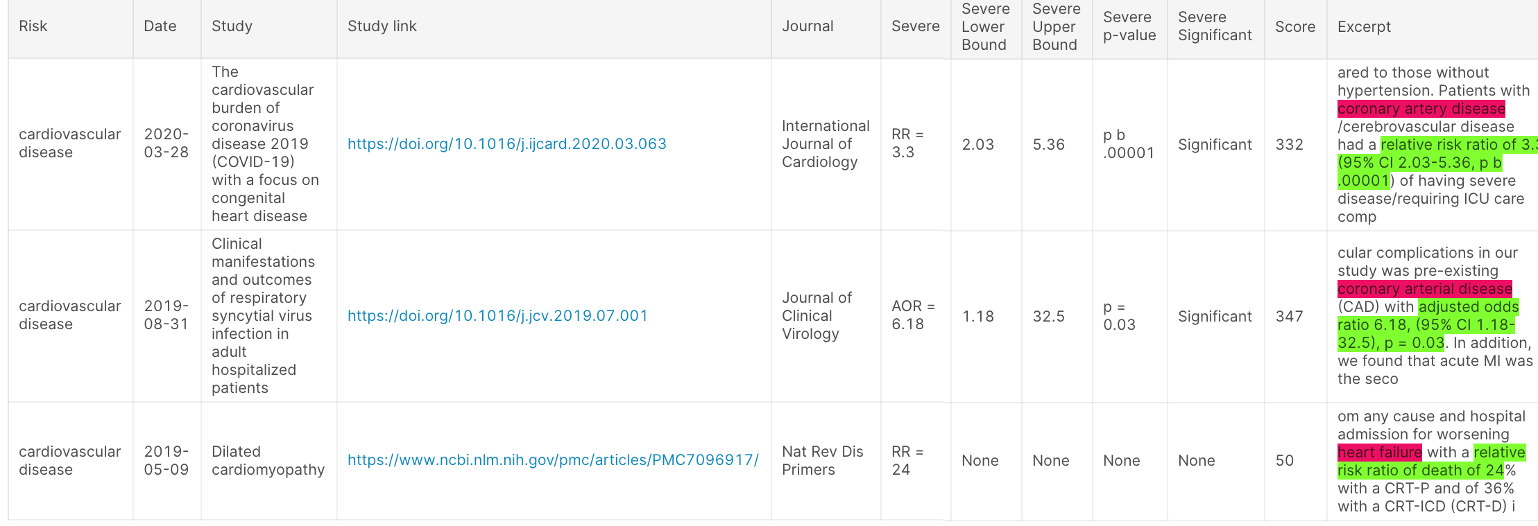

Please feel free to reuse, cite contribution and up vote please.


# Notebook parameters<a class="anchor" id="parameters-header"></a>
![](http://)
We set here the global parameters to be used accross the entire notebook.

In [ ]:
risk_factor_terms = {
    'age': ['age', 'children', 'elder', 'infant*', 'old', 'older', 'senior', 'year old', 'years old', 'young', 'younger'],
    'cancer': ['cancer', 'cancer of the blood', 'carcinoma', 'leucaemia', 'leukemia', 'lung cancer', 'lymphoma', 'malignant neoplasm', 'malignant neoplastic disease', 'malignant tumor', 'metastatic tumor'],
    'cardiovascular disease': ['abnormal heart rhytmns', 'aorta disease', 'angina', 'cardiomyopathy', 'cardiovascular', 'cardiovascular disease', 'congenital heart disease', 'congestive heart failure', 'coronary', 'coronary arterial disease', 'coronary artery disease', 'deep vein thrombosis', 'heart attack', 'heart failure', 'heart valve disease', 'ischemic heart disease', 'Marfan syndrome', 'pericardial disease', 'peripheral vascular disease', 'pulmonary embolism', 'rheumatic heart disease', 'specified heart arrhytmia', 'vascular disease'],
    'cerebrovascular disease': ['aneurysm', 'cerebr*', 'embolism', 'haemorragic stroke', 'hemorrhagic stroke', 'ischemic stroke', 'sybarachnoid hemorrhage', 'TIA', 'unspecified stroke', 'stroke'],
    'chronic kidney disease': ['chronic kidney disease', 'kidney'],
    'chronic liver disease': ['chronic liver disease', 'cirrhosis', 'hepatocellular carcinoma', 'hepatitis', 'liver'],
    'COPD': ['chronic obstructive pulmonary disease', 'COPD'],
    'diabetes': ['diabetes'],
    'drinking': ['alcohol*', 'drinking'],
    'hypertension': ['high blood pressure', 'hyperpiesia', 'hyperpiesis', 'hypertensive', 'hypertension'],
    'male gender': ['gender', 'male', 'man', 'men', 'sex'],
    'obesity': ['morbidly obese', 'morbidly overweight', 'obes*', 'overweight'],
    'respiratory system disease': ['apnea', 'asbestosis', 'asthma', 'bronciectasis', 'bronchiolitis', 'bronchitis', 'chest infection', 'chronic cough', 'common cold', 'cough', 'cystic fibrosis', 'emphysema', 'hantavirus', 'idiopathic pulmonary fibrosis', 'influenza', 'laryngitis', 'lung infection', 'pertussis', 'pleural effusion', 'pleurisy', 'pneumonia', 'pulmonary embolism', 'pulmonary hypertension', 'pulmonary nodules', 'respiratory', 'respiratory disease', 'respiratory syncytial virus', 'respiratory system disease', 'sarcoidosis', 'sinus infection', 'sinusitis', 'sleep apnea', 'tonsilitis', 'tuberculosis', 'work-related asthma'],
    'smoking': ['cigarette*', 'smok*', 'tobacco']
}

covid19_synonyms = ["coronavirus disease 19", "sars cov 2", "2019 ncov", "2019ncov", "coronavirus 2019", "wuhan pneumonia", "wuhan virus", "wuhan coronavirus", "covid19", "covid-19"]

# Max documents to search per Lucene query (set it to e.g. 1000000 to return all possible matches)
MAX_SEARCH_RESULTS = 1000000
# Min grammar match score required to keep a match, the lesser the score the more tokens we allow between the ocurrences of a risk factor and a severe measure
# Each token between the risk factor and the severe measure penalizes the overall score by 15 points
# We allow for at least 40 tokens in between (roughly the lenght of 2 sentences), which will add -15*40=-600 points to the overall match score
MIN_GRAMMAR_SCORE = -600
# Left and right context size in characters to extract upon a grammar match (roughly 10 words, assuming 5 chars per word on average)
CONTEXT_SIZE = 50
# Styles for highlighting the matched risk factor and severe measures within the full text of the papers
RISK_FACTOR_STYLE = "background-color: #EC1163"
SEVERE_STYLE = "background-color: #80FF32"

# Install Libraries and Load Metadata<a class="anchor" id="install-header"></a>
![](http://)
A number of external components are used, including Apache Lucene with pre-compiled indexes and the GrapeNLP grammar engine for information extraction. In this kernel, we provide an installation/ configuration/ compilation package for PyLucene 8.1.1 as an external data called “compiledlucene”, which provides all the required software dependencies for installation and deployment of PyLucene. For the installation of GrapeNLP, we reuse the libgrapenlp dataset, which provides the required Debian packages, then we install from Pypi the GrapeNLP Python interface package: pygrapenlp. More details on how to install and use the GrapeNLP grammar engine in a Kaggle notebook can be found here: https://www.kaggle.com/javiersastre/grapenlp-grammar-engine-in-a-kaggle-notebook

In [ ]:
# Install and import relevant libraries
!python -m easy_install ../input/compiledlucene/bk/lucene-8.1.1-py3.6-linux-x86_64.egg
!cp -r ../input/compiledlucene/bk/JCC-3.7-py3.6-linux-x86_64.egg /opt/conda/lib/python3.6/site-packages/
import sys
sys.path
sys.path.append('/opt/conda/lib/python3.6/site-packages/JCC-3.7-py3.6-linux-x86_64.egg')
sys.path.append('/opt/conda/lib/python3.6/site-packages/lucene-8.1.1-py3.6-linux-x86_64.egg')

In [ ]:
!dpkg -i ../input/libgrapenlp/libgrapenlp_2.8.0-0ubuntu1_xenial_amd64.deb
!dpkg -i ../input/libgrapenlp/libgrapenlp-dev_2.8.0-0ubuntu1_xenial_amd64.deb
!pip install pygrapenlp

In [ ]:
import sys, os, lucene, threading, time, html
from datetime import datetime
from java.nio.file import Paths
from org.apache.lucene.analysis.miscellaneous import LimitTokenCountAnalyzer
from org.apache.lucene.document import Document, Field, FieldType
from org.apache.lucene.index import FieldInfo, IndexWriter, IndexWriterConfig, IndexOptions
from org.apache.lucene.analysis.standard import StandardAnalyzer
from org.apache.lucene.index import DirectoryReader
from org.apache.lucene.queryparser.classic import QueryParser
from org.apache.lucene.store import SimpleFSDirectory
from org.apache.lucene.search import IndexSearcher

LUCENE_INDEX_DIR = "documentLevel"
LUCENE_BASE_DIR = "/kaggle/working"
COVID_FULLTEXT_DF = "../input/covidfulltext/metadata_and_fulltext_2020-04-17.csv"

In [ ]:
from collections import OrderedDict
from pygrapenlp import u_out_bound_trie_string_to_string
from pygrapenlp.grammar_engine import GrammarEngine

In [ ]:
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import bs4 as bs
import urllib.request
from time import sleep
import os
from IPython.display import display, Image, HTML

# Load Lucene Index and Searcher<a class="anchor" id="load-lucene-header"></a>
![](http://)
Load the Lucene index using IndexWriter. This component manages an index over a dynamic collection of documents and provides very rapid updates to the index as documents are added and deleted from the collection. This index provides a mapping from terms to documents, which is called an “inverted index. Document indexing consists of first constructing a Lucene Document that contains the fields to be indexed, then adding that Document to the inverted index”, see figure below. The index is maintained as a set of segments in a storage abstraction called SimpleFSDirectory which provides an interface similar to an OS file system.

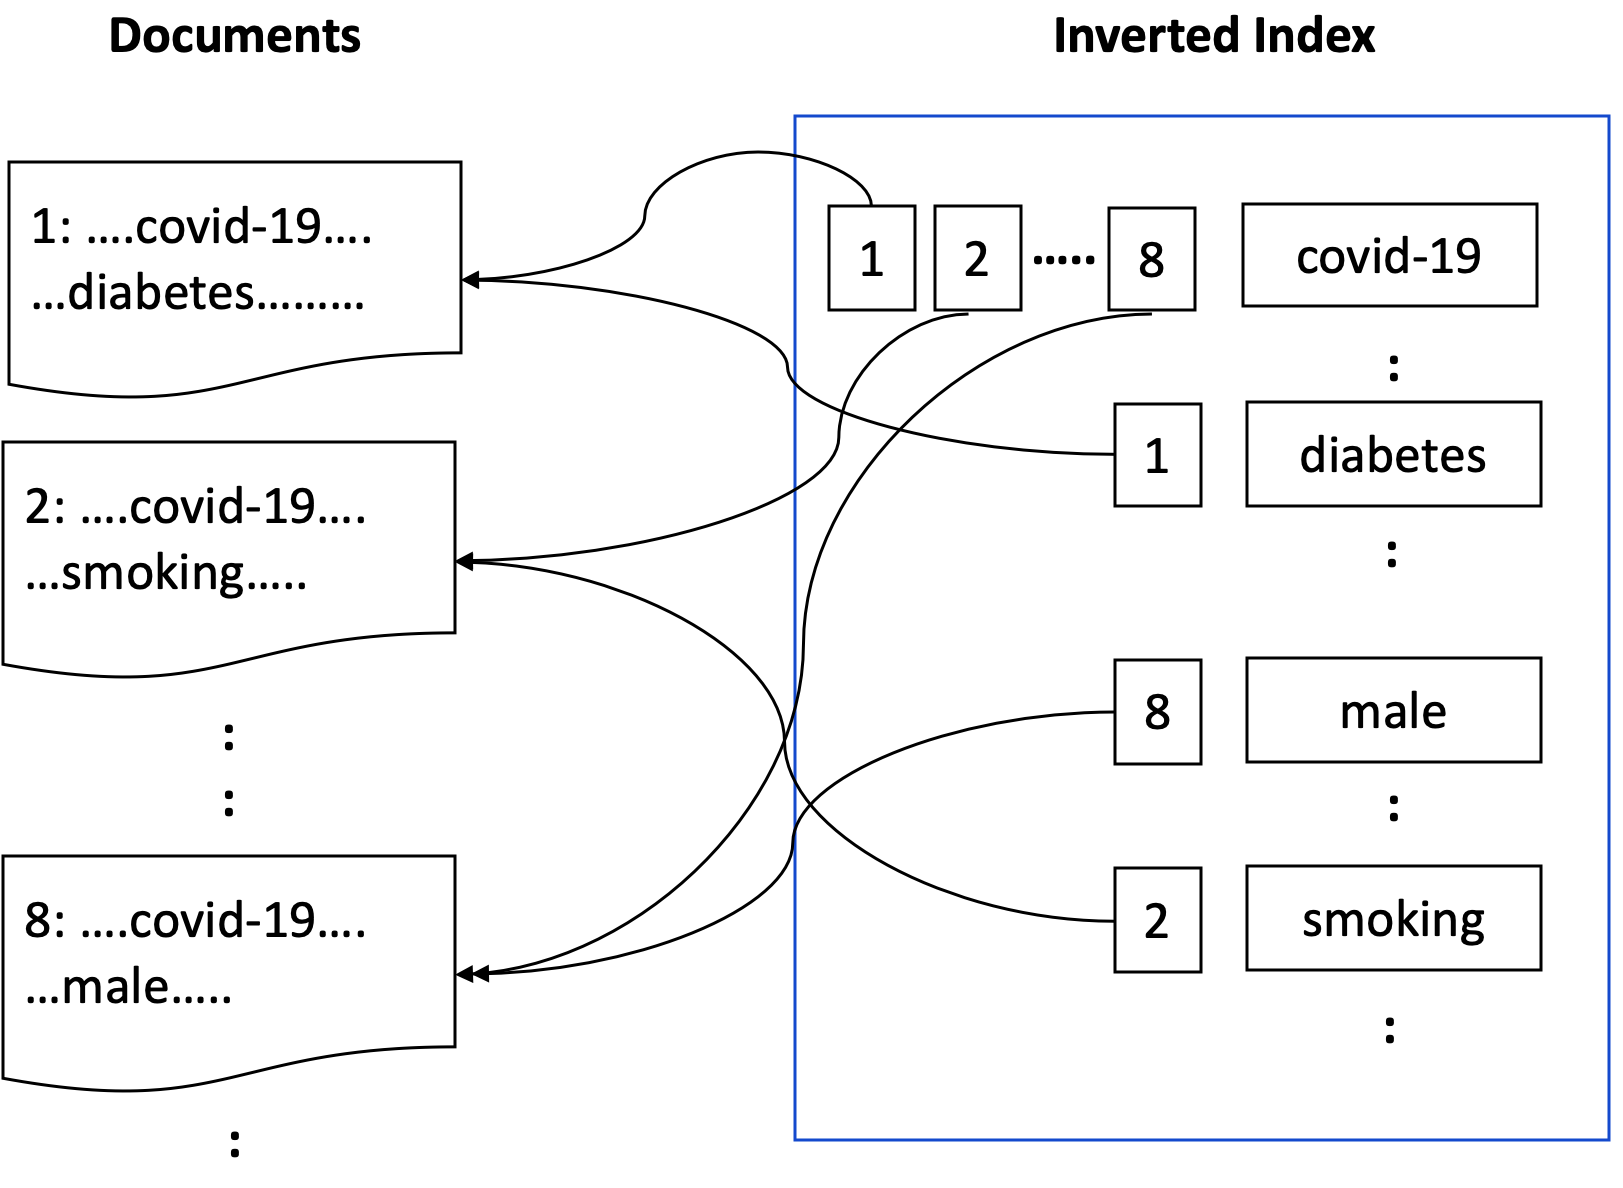

In this kernel, we define each paper as a “Document” and the corresponding metadata of the paper as “Fields” of the Document. Also, we store the frequency of terms as well as their position and offsets in document and this option gives us an opportunity to do more complicated and flexible querying such as “phrasal querying”.

In [ ]:
# Load indexed metadata 
metadata = pd.read_csv('../input/covidfulltext/metadata_and_fulltext_2020-04-17.csv')
metadata.shape

In [ ]:
%%capture --no-display
# This section loads the indexs and takes about 4 minutes to run
class Ticker(object):

    def __init__(self):
        self.tick = True

    def run(self):
        while self.tick:
            sys.stdout.write('.')
            sys.stdout.flush()
            time.sleep(1.0)

class IndexFiles(object):
    """Usage: python IndexFiles <doc_directory>"""

    def __init__(self, root, storeDir, analyzer):
        ##print("before store")
        if not os.path.exists(storeDir):
            os.mkdir(storeDir)
        ##print("after store")

        store = SimpleFSDirectory(Paths.get(storeDir))
        ##print(storeDir)
        analyzer = LimitTokenCountAnalyzer(analyzer, 1048576)
        ##print("after analyzer ")

        config = IndexWriterConfig(analyzer)
        ##print("after config")

        config.setOpenMode(IndexWriterConfig.OpenMode.CREATE)
        ##print("before writer")
        writer = IndexWriter(store, config)
        ##print("after writer")
        self.indexDocs(root, writer)
        ticker = Ticker()
        ##print ('commit index')
        threading.Thread(target=ticker.run).start()
        writer.commit()
        writer.close()
        ticker.tick = False
        ##print ('done')

    def indexDocs(self, root, writer):

        t1 = FieldType()
        t1.setStored(True)
        t1.setTokenized(False)
        t1.setStoreTermVectors(True)
        t1.setStoreTermVectorOffsets(True)
        t1.setStoreTermVectorPositions(True)
        t1.setIndexOptions(IndexOptions.DOCS_AND_FREQS_AND_POSITIONS_AND_OFFSETS)
        

        t2 = FieldType()
        t2.setStored(True)
        t2.setTokenized(True)
        t2.setStoreTermVectors(True)
        t2.setStoreTermVectorOffsets(True)
        t2.setStoreTermVectorPositions(True)
        t2.setIndexOptions(IndexOptions.DOCS_AND_FREQS_AND_POSITIONS_AND_OFFSETS)
                
        i = 1
        for index, row in tqdm(metadata.iterrows(), desc='Indexing: ', total=len(metadata.index)):
            print ("adding ", i , "th document:", row['paper_id'])
            try :
                doc = Document()
                doc.add(Field("paper_id", row['paper_id'], t1))
                doc.add(Field("title", row['title'], t2))
                doc.add(Field("doi",row['doi'], t1))
                doc.add(Field("pmcid", row['pmcid'], t1))
                doc.add(Field("publish_time", row['publish_time'], t1))
                doc.add(Field("journal", row['journal'], t1))
                doc.add(Field("url", row['url'], t1))
                
                if len(row['text']) > 0:
                    doc.add(Field("full_text", row['text'], t2))
                else :
                    print ("warning: no fulltext available in %s", row['title'])
                    
                if len(row['abstract_y']) > 0:
                    doc.add(Field("abstract", row['abstract_y'], t2))
                else :
                    print ("warning: no abstract available in %s", row['title'])
                writer.addDocument(doc)
            except (RuntimeError, TypeError, NameError):
                pass
            i=i+1
            

lucene.initVM()
start = datetime.now()
try:
    IndexFiles(LUCENE_BASE_DIR, os.path.join(LUCENE_BASE_DIR, LUCENE_INDEX_DIR),StandardAnalyzer())
    end = datetime.now()
    print (end - start)
except (RuntimeError, TypeError, NameError):
    print ("Failed: ")
    raise 

Define utility functions to make Lucene query expressions and perform a search in Lucene. The latter method takes a search query and returns a set of documents ranked by their relevancy/ similarity to the query. QueryParser provides a highly configurable hybrid form of search on search topics such as “phrasal search” , “Boolean search” , “proximity search” and etc. Also, search topics can be field specific because Lucene indexes terms as a composition of a field name and a token.

In [ ]:
def make_or_term_query(terms):
    quoted_terms = terms.copy()
    for i in range(len(quoted_terms)):
        if ' ' in quoted_terms[i]:
            quoted_terms[i] = '"' + quoted_terms[i] + '"'
    return ' OR '.join(quoted_terms)

def make_and_query(subqueries):
    return "(" + ") AND (".join(subqueries) + ")"

def search(searcher, analyzer, query_expression):
    query = QueryParser("full_text", analyzer).parse(query_expression)
    scoreDocs = searcher.search(query, MAX_SEARCH_RESULTS).scoreDocs
    results = []
    for scoreDoc in scoreDocs:
        doc = searcher.doc(scoreDoc.doc)
        result = {
            'date': doc.get("publish_time"),
            'study': doc.get("title"),
            'study_link': doc.get("url"),
            'journal': doc.get("journal"),
            'paper_id': doc.get('paper_id'),
            'paper_full_text': doc.get('full_text'),
            'pmcid': doc.get("pmcid")
        }
        results.append(result)
    return pd.DataFrame(results)

Instantiate the Lucene objects needed to perform searches

In [ ]:
directory = SimpleFSDirectory(Paths.get(os.path.join(LUCENE_BASE_DIR, LUCENE_INDEX_DIR)))
searcher = IndexSearcher(DirectoryReader.open(directory))
analyzer = StandardAnalyzer()

# Search for Publications with Relevant Tables <a class="anchor" id="search-tables-header"></a>
![](http://)
The following section searches for publications that may contain tables relevant to risk factors, based on Apache Lucene.

In [ ]:
clinical_expression = make_or_term_query(['clinical', 'epidem*', 'virological', 'host susceptibility to serve'])
covid19_expression = make_or_term_query(covid19_synonyms)
query_expression = make_and_query([clinical_expression, covid19_expression])
print('query: ', query_expression)
df_relevant_papers = search(searcher, analyzer, query_expression)
print("{} documents found".format(len(df_relevant_papers.index)))


In [ ]:
# Examine results 
df_relevant_papers.head()

[](http://)Filtering articles that have a PMCID, as these publications store tabular data on PubMed.


In [ ]:
# Only use papers that have a PMCID
df_relevant_papers = df_relevant_papers[~df_relevant_papers['pmcid'].str.contains('NaN')]

In [ ]:
# This list will be used to pull publication data from PubMed servers
relevant_papers = df_relevant_papers.pmcid.values

# Download Tables <a class="anchor" id="download-tables-header"></a>
![](http://)
This section will retrieve tables from the publications that have a PMCID, as these publications store tabular data on PubMed. To avoid a timeout due to the long time required for downloading tables of thousands of papers, we have pre-downloaded the tables of more than 71K papers and saved them into the pmc-tables dataset. In case the tables of a given paper are not in the dataset, they will be downloaded from PubMed.

In [ ]:
PMC_FOLDER = os.path.join('..', 'input', 'pmc-tables')

def download_article_tables(pmcid, print_tables=True, use_cached_tables=True):
#     print("", end = '.')
    source = None
    from_cache = 0
    from_pubmed = 0

    # If requested to use cached tables and the table is in the cache, load it from the cache
    if use_cached_tables:
        cached_table_file = os.path.join(PMC_FOLDER, pmcid + '.xml')
        if os.path.exists(cached_table_file):
            with open(cached_table_file, 'rb') as fp:
                source = fp.read()
            from_cache += 1

    # If requested not to use the cached tables or the needed table was not in the cache, download it
    if not source:
        sleep(0.5) # This line is needed as the NCBI server will block if there are too many frequent requests
        url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pmc&id={0}'.format(pmcid)
        #beautiful soup
        source = urllib.request.urlopen(url).read()
        from_pubmed += 1

    soup = bs.BeautifulSoup(source,'lxml')
    df = None
    cols = None
    dfs = []
    title = ''
    abstract = ''
    journal = ''
    title = soup.findAll('article-title')[0].find(text=True)# title
    try:
        abstract = soup.find("abstract").text
    except:
        abstract = ''
    #getting the table
    tables = soup.findAll('table')  # Note: 
    i = 1
    for table in tables:
        if(print_tables):
            print("\nTable {0}  for paper id {1}: ".format(i, pmcid))
        table_rows = table.find_all('tr')
        #generate df
        df = pd.DataFrame()
        for tr in table_rows:
            td = tr.find_all(['td'])
            row = [i.text for i in td]
            
            if(len(row) > 0):
                s = pd.Series(row)
                df = df.append(s, ignore_index=True)
            else: # it is a header
                th = tr.find_all(['th'])
                cols = [i.text for i in th]
        
        if(cols): #assign header
            if(len(df.columns) == len(cols)+1):
                #add one column for the title
                cols.insert(0,'')
            if(len(df.columns) == len(cols)):
                df.columns = cols
        
        dfs.append( df )
        if(print_tables):
            print(title)
            print(abstract)
            display(HTML(df.to_html()))
        i = i + 1

    return dfs, from_cache, from_pubmed

In [ ]:
unique_pmcids = df_relevant_papers[~df_relevant_papers['pmcid'].str.contains('NaN')].pmcid.unique().tolist()
unique_pmcids.sort()
# Save needed PMCIDs for offline download of corresponding tables
with open('pmcids.txt', 'wt', encoding='UTF-8') as fp:
    for pmcid in unique_pmcids:
        fp.write(pmcid)
        fp.write('\n')

Download the tables of all PMCID papers / load them from the cache in the pmc-tables dataset when available

In [ ]:
%%capture --no-display
tables_by_pmcid = {}
from_cache = 0
from_pubmed = 0
for pmcid in tqdm(unique_pmcids, desc='Downloading:'):
    try:
        df_list, from_cache_inc, from_pubmed_inc = download_article_tables(pmcid, print_tables=False)
        from_cache += from_cache_inc
        from_pubmed += from_pubmed_inc
        if len(df_list) > 0:
            tables_by_pmcid[pmcid] = df_list
    except Exception as e:
        display(HTML("<p>Unable to download tables for PMCID {}; error message: {}</p>".format(pmcid, str(e))))
display(HTML("<p>Cached papers/downloaded papers: {}/{}".format(from_cache, from_pubmed)))

In [ ]:
# Print some stats on tables 
table_count = 0
pmcid_count = len(unique_pmcids)
pmcid_with_tables_count = 0
for pmcid, tables in tables_by_pmcid.items():
    table_count += len(tables)
    pmcid_with_tables_count += 1
print('Total PMCID papers: {}'.format(pmcid_count))
print('Number of PMCID papers with tables: {} ({:.2%})'.format(pmcid_with_tables_count, pmcid_with_tables_count / pmcid_count))
print('Total tables downloaded: {}'.format(table_count))
print('Average number of tables per PMCID paper: {}'.format(1.0 * table_count / pmcid_count))

# Compute Odds Ratio <a class="anchor" id="odds-header"></a>
![](http://)
As we are analysing count data, such as the number of severe outcomes versus the number of non-severe outcomes, we will compute the summary statistics using an odds ratio. 
The term “odds” refers to the probability of an event occurring versus the probability of the event not occurring.

These can be illustrated with the following example, based on [Ranganathan](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4640017):

| | Fatal | Survive | Total |
| --- | --- | --- | --- |
| A | 18 | 46 | 64 |
| B | 29 | 36 | 65 |
| Totals | 47 | 82 | 129 |

Odds is defined as:

$$Odds = \frac{Fatal}{Survive}$$

The odds of death in group A is 18/46 (0.39) and in group B it is 29/36 (0.81).

The odds *ratio* (OR) is the ratio of the odds of an event in group A to the odds of an event in group B. 

Our Covid-19 data is mainly from retrospective cohort studies, which are studies that examine existing data to identify risk factors for particular conditions, therefore we will utilise  odds  ratio.

In [ ]:
def get_statistical_info(severity_numbers):
#severity_number pattern: non-severity, non-severity_n, severity, severity_n
    OR, lower_CI, higher_CI, CI, p_value = 0.0, 0.0, 0.0, 0.0, 0.0
    ##Cases with positive (bad) outcome
    a = severity_numbers[2]     # Number in exposed group
    b = severity_numbers[3] - a # Number in control group

    ##Cases with negative (good) outcome
    c = severity_numbers[0]     # Number in exposed group
    d = severity_numbers[1] - c # Number in control group
    
    if(a == 0 or b <= 0 or c == 0 or d <=0): # cannot calculate division by 0 or sqrt < 0
        return OR, lower_CI, higher_CI, CI, p_value
    
    
    OR = (a*d)/(b*c)
    std_error  = np.sqrt(1/a + 1/b + 1/c +1/d) 
    
    lower_CI = np.exp(np.log(OR)-1.96*std_error)
    higher_CI = np.exp(np.log(OR)+1.96*std_error)
    
    CI = "95% CI: {:.2f}-{:.2f}".format(lower_CI, higher_CI)
    
    #P-value: φ(z) = (1 / √2π) × e -z2/2
    z = np.log(OR) / std_error
    
    p_value = (1/(np.sqrt(2*np.pi))) * np.exp(-(z**2)/2)
    
    #return "OR: {:.2f} ({:}) p={:.2f}".format(OR, CI, p_value)
    return OR, lower_CI, higher_CI, CI, p_value
    

# Extract Information from Tables <a class="anchor" id="manual-header"></a>
![](http://)
We are relying on the search above to identify the most relevant tables.
This section will get information from the extracted tables related to a given risk factor. 

** However, this works best for a fixed set of consistent table styles.** The system can be updated in the future to accommodate more diverse tables.

In [ ]:
#Input: the dataframe you are looking for and the set of synonyms to search in the header
#Output: the indexes where the non severe and severe cases are described, in this order.
def get_column_index_severities(df, severe_synonyms_set):
    
    synonyms_non = set(["non", "non ","non-","no ","dead","death","died","3","mort"])

    row = list(df.columns)
    
    severe_index = None
    non_severe_index = None
    
    severe_value = ""
    non_severe_value = ""

    for i, r in enumerate(row):
        r = str(r).lower().replace('‐', '-')
        #print("r is",r)
        for sv in severe_synonyms_set:
            if(sv in r):   
                #print("Checking",sv)
                #check if its not severe
                severe_value = sv
                for n in synonyms_non:
                    #print("Checking",sv," and",n)
                    if(n+sv in r) or (n in r):
                        non_severe_index = i
                        non_severe_value = n
                        #print("n"+n)
                        break
                
                if(not non_severe_index):
                    severe_index = i

                if(severe_index and non_severe_index):
                    #print("Found index for " + severe_value + " and " + non_severe_value)
                    return [non_severe_index, severe_index]                
                
                break #not necessary to look for more synonyms on severe set
    return [non_severe_index, severe_index]

In [ ]:
def get_only_number(val):
    if isinstance(val, str):
        i = val.find("(")
        if(i > 0):
            val = val[0:i]
        i = val.find("/")
        if(i > 0):
            val = val[0:i]
    try:
        f = float(val)
        return f
    except:
        return 0

def get_total_number(header):
    
    val = header[header.find("=")+1:header.find(")")].strip() #pattern (n = 12)
    if(val.isdigit()):
        return int(val)
    return 0
    

def get_numbers_by_risk_factor(df, risk_factor_synonyms, header_synonyms):
    # Remove Lucene's query wilcard * from synonyms and lowercase them all
    synonyms = [risk_factor_synonym.lower().replace('*', '') for risk_factor_synonym in risk_factor_synonyms]
    # Search for risk factor synonyms in row headers starting with the longest ones
    synonyms.sort(key=lambda s: len(s), reverse=True)
    non_severe_index, severe_index = get_column_index_severities(df, header_synonyms)
    
    if(not non_severe_index or not severe_index):
        # print("Info: Severity not found on header")
        return
        
    # Search for a risk factor synonym
    for synonym in synonyms:
        row = df[df.iloc[:,0].str.lower().str.contains(synonym)].values
        if len(row) > 0: # if found synonym, stop search
            break
    if len(row) == 0: # no synonym not found 
        # print("Info: Risk factor not found")
        return None
    row = row[0]
    
    header = list(df.columns)

    if non_severe_index:
        non_severe = get_only_number(row[non_severe_index])
        non_severe_n = get_total_number(header[non_severe_index])

    if severe_index:
        severe = get_only_number(row[severe_index])
        severe_n = get_total_number(header[severe_index])

    return [non_severe, non_severe_n, severe, severe_n]


def get_severity_numbers(df, risk_factor_synonyms):
    severe_synonyms = set(["severe", "critical", "icu", "picu","poor","mild","ecmo", "mv","gi","corticosteroids","2"])
    return get_numbers_by_risk_factor(df, risk_factor_synonyms, severe_synonyms)

def get_fatality_numbers(df, risk_factor_synonyms):
    fatality_synonyms = set(["surviv"])
    return get_numbers_by_risk_factor(df, risk_factor_synonyms, fatality_synonyms)

In [ ]:
def extract_from_tables(tables_by_pmcid, risk_factor, risk_factor_synonyms, metadata):
# Extracts from the paper tables the target datapoints for the given risk factor
    result_df = pd.DataFrame(columns=['Risk','Date', 'Study','Study Link','Journal','Severe','Severe lower bound','Severe upper bound','Severe p-value','Severe Significant', 'Score', 'Excerpt'])
    for pmcid, tables in tqdm(tables_by_pmcid.items(), desc=risk_factor + ': '):
        paper_data_dict = {}
        #get information from the metadata
        paper_info = metadata[metadata.pmcid == pmcid][['title', 'publish_time', 'source_x', 'url', 'pmcid','journal']]
        paper_info = paper_info.iloc[0]
        for df in tables:
            df.columns = df.iloc[0]
            severe_numbers = get_severity_numbers(df, risk_factor_synonyms)
         
            if severe_numbers: 
                severe_OR, severe_lower_CI, severe_higher_CI, severe_CI, severe_p_value = get_statistical_info(severe_numbers)
                if severe_OR:
                    if (float(severe_p_value)<0.05):
                        significant = "Significant"
                    else:
                        significant = "Not Significant"
                    date = None
                    if paper_info.publish_time:
                        date = html.escape(paper_info.publish_time)
                    study = None
                    if paper_info.title:
                        study = html.escape(paper_info.title)
                    study_link = None
                    if paper_info.url:
                        study_link = '<a href="' + paper_info.url + '">' + html.escape(paper_info.url) + '</a>'
                    journal = None
                    if paper_info.journal:
                        journal = html.escape(str(paper_info.journal)),
                    
                    paper_data_dict = {
                        'Risk': html.escape(risk_factor),
                        'Date': date,
                        'Study': study,
                        'Study Link': study_link,
                        'Journal': journal,
                        'Severe': severe_OR,
                        'Severe lower bound': severe_lower_CI,
                        'Severe upper bound': severe_higher_CI,
                        'Severe p-value': severe_p_value,
                        'Severe Significant': significant,
                        'Score': None, # Not used here, used in the grammar approach for the match score
                        'Excerpt': None # Not used here, used in the grammar approach to show the matched text with context
                    }
                    result_df = result_df.append(paper_data_dict, ignore_index=True)
                    break

    return result_df

In [ ]:
%%capture --no-display
# Generate target tables
tables_by_risk_factor_part_1 = {}
for risk_factor, risk_factor_synonyms in tqdm(risk_factor_terms.items(), desc="Extracting: "):
    #print("\nTable for risk factor {}".format(risk_factor)
    tables_by_risk_factor_part_1[risk_factor] = extract_from_tables(tables_by_pmcid, risk_factor, risk_factor_synonyms, metadata)

In [ ]:
%%capture --no-display
for risk_factor, table in tables_by_risk_factor_part_1.items():
    display(HTML(table.to_html(escape=False)))

# Search for Publications with Relevant Text <a class="anchor" id="search-text-header"></a>
![](http://)
We reuse the previously loaded Lucene index and search engine to find papers whose text may contain the relevant information extract for each risk factor and its corresponding synonyms, which are defined in this notebook's parameters section.

In [ ]:
covid19_expression = make_or_term_query(covid19_synonyms)
risk_factor_queries = {risk_factor: make_and_query([make_or_term_query(synonyms), covid19_expression]) for risk_factor, synonyms in risk_factor_terms.items()}
papers_by_risk_factor = {}

for risk_factor, query_expression in tqdm(risk_factor_queries.items(), desc='Searching: '):
    results = search(searcher, analyzer, query_expression)
    papers_by_risk_factor[risk_factor] = results
    print("{}: {} documents found".format(risk_factor, len(results.index)))

# Extraction Grammar Description <a class="anchor" id="grammar-description-header"></a>
![](http://)
Grammars have greater expressive power compared to regular expressions, so we have developed a [GrapeNLP](https://github.com/GrapeNLP) grammar for the extraction of severe measures that are within a maximum distance from a mention of a given risk factor synonym. This grammar performs a similar operation than a regular expression with extraction groups: it will try to match the entire text of each paper, then upon a match it will extract segments of the matched text that are bounded in the grammar by XML tags. The XML tags act as parenthesis in regular expressions for defining extraction groups, allowing later retrieval of the matched portions of text in each group, using the tag names instead of group indexes. We extract the following segments from the text:
* the severity metric (OR, HR, RR, WDM, AOR, AHR or AOR)
* confidence interval bounds, lower and upper
* p-value
* the original excerpt of text mentioning both the risk factor and severe measure, for manual reviewing

GrapeNLP is an efficient grammar engine based on push-down automata with output, where the outputs are used both for generating the XML tags and for assigning scores to each matched token, depending on the specificity degree of the lexical mask used to match the token: by default, the most restrictive lexical masks (the ones matching a specific word or symbol only) get 14 points, while the *<TOKEN>* mask, which matches any token, gets 0 points. In case the entire text can be matched through different paths in the grammar, the grammar engine efficiently selects the one with the greatest overall score using a Viterbi-like algorithm in order to later extract the corresponding segments.
    
The grammars can be structured into reusable components (equivalent to non-terminal symbols of context-free grammars) as illustrated by the grammar axiom:

In [ ]:
Image("../input/severe-grammar/axiom_severe.png")

This grammar looks for pairs of mentions *risk factor*/*severe measure* that are close enough. There are 3 possible combinations: 1) the risk factor precedes the severe measure, 2) the risk factor is embedded inside the severe measure (e.g. OR 3.4 59 years olds; 95% CI 1.4-9.5), or the risk factor appears after the severe measure. Since the grammar performs exact match of the entire paper, it uses the *null_insert* grammar to match the text that may appear before and after the text we are looking for, but only extracts the relevant datapoints.

In [ ]:
Image("../input/severe-grammar/null_insert.png")

This grammar matches 0, 1 or more arbitrary tokens, giving 0 points to each match. To match the arbitrary text that may appear between the risk factor mention and the severity measure, we use the **penalizing_insert** grammar, which overrides the default 0 point score in order to penalize longer inserts and consequently favor the closest *risk factor*/*severe* pair:

In [ ]:
Image("../input/severe-grammar/penalizing_insert.png")

The **penalizing_insert** grammar extracts the matched text for subsequent generation of the publication excerpt for later inspection (note the use of output tag).

The **risk_factor_alone_or_in_list** grammar detects different terms relative to each risk factor category, either alone or in a list of risk factors:

In [ ]:
Image("../input/severe-grammar/risk_factor_alone_or_in_list.png")

It makes use of 2 other risk factor grammars, **risk_factor** and **target_risk_factor**, the difference being that **risk_factor** accepts any risk factor while **target_risk_factor** accepts only the type of risk factor we are looking for (e.g. age only, or cancer only, etc.). In case there is a list of risk factors, the entire segment of text from the first to the last target risk factors will be captured. Note in the previous section we have compiled lists of papers for each one of the considered risk factors. We apply the same grammar to all the papers, but for each risk factor we use a grammar context variable to specify which type of risk factor the **target_risk_factor** grammar should look for:

In [ ]:
Image("../input/severe-grammar/risk_factor.png")

In [ ]:
Image("../input/severe-grammar/target_risk_factor.png")

The GrapeNLP grammar engine ingests both an input text and a set of key/value pairs (the context variables), which can be checked in a grammar box by means of meta codes <@key=value> in order to only enable certain grammar paths.

Each **risk_factor_XXX** defines the possible synonyms and expressions for each risk factor type, for instance grammar **risk_factor_respiratory_system_disease**:

In [ ]:
Image("../input/severe-grammar/risk_factor_respiratory_system_disease.png")

Note the <E> meta code represents the empty string, which can be used to make a box optional. Note as well that some risk factor synonyms are shorter versions of others, such as cough and dry cough. Since lexical masks matching specific words or symbols are given 14 points by default, the longest match will be selected.
    
The **severe** grammar detects the actual datapoints we want to extract, which are expressed in the papers in a variety of forms:

In [ ]:
Image("../input/severe-grammar/severe.png")

To identify the provided metric independently of the form used (e.g. "OR" or "odds ratio"), we consistently generate the same empty tag for each set of metric synonyms:

In [ ]:
Image("../input/severe-grammar/metric.png")

Between the mention of the metric and its value we allow an arbitrary amount of words, numbers and punctuation symbols, but not a full stop. Each aditional token in this gap is penalized with -15 points to priorize the smallest **gap**:

In [ ]:
Image("../input/severe-grammar/gap.png")

The **comparison_operator** grammar generates empty XML tags to identify the comparison operator used, regardless of the expression used:

In [ ]:
Image("../input/severe-grammar/comparison_operator.png")

Grammars **value** and **float_interval** are used to extract the measure value and confidence interval:

In [ ]:
Image("../input/severe-grammar/value.png")

In [ ]:
Image("../input/severe-grammar/float_interval.png")

Grammar **p_value** extracts the entire p-value expression (e.g. p < 0.05) as well as the value only in order to determine significance:

In [ ]:
Image("../input/severe-grammar/p_value.png")

We include in the *severe_grammar* dataset the full list of GRF grammar files, which can be viewed and edited with the Unitex Corpus Processing suite (available at https://unitexgramlab.org/). Using this intuitive graphical user interface tool, users can reconfigure the grammars provided or add new grammars. For the efficient application of the grammar to a text, the GRF files are first converted into a single FST2 file (grammar_severe.fst2) that stores an equivalent and pseudo-minimized recursive transition network with output, a kind of push-down automaton. This conversion can be done with the Grf2Fst2 command included in Unitex. More information can be found on [this notebook](https://www.kaggle.com/javiersastre/grapenlp-grammar-engine-in-a-kaggle-notebook).

# Load GrapeNLP grammar <a class="anchor" id="load-grammar-header"></a>
![](http://)

In [ ]:
grammar_dir = os.path.join('..', 'input', 'severe-grammar')
bin_delaf_pathname = os.path.join(grammar_dir, 'dictionary.bin')
severe_grammar_pathname = os.path.join(grammar_dir, 'grammar_severe.fst2')
severe_grammar_engine = GrammarEngine(severe_grammar_pathname, bin_delaf_pathname)

# Extract Information from Text <a class="anchor" id="extract-from-text-header"></a>
![](http://)
We apply here the loaded grammar to the full text of each paper found, for each risk factor defined in the first section of this notebook.

The grammar engine is implemented in C++, and the corresponding native match object accessed from Python using SWIG. We use the following function to convert this native object into a Python dictionary which is easier to process. Upon multiple matches of the same expression, we retrieve the top scored match. The grammar not only matches expressions but tags the fragmets to extract (what we call "segments" of the input text) For the top scored match, this method returns a Python dictionary for all the tagged text segments, using as key the label of the tag and as value the text segment itself. The total match score is also returned in order to be able to enforce a minimum score.

In [ ]:
def grapenlp_results_to_python_dic(sentence, native_results):
    top_segments = OrderedDict()
    score = -sys.maxsize - 1 # Minimum integer value
    if not native_results.empty():
        top_native_result = native_results.get_elem_at(0)
        score = top_native_result.w
        top_native_result_segments = top_native_result.ssa
        for i in range(0, top_native_result_segments.size()):
            native_segment = top_native_result_segments.get_elem_at(i)
            native_segment_label = native_segment.name
            segment_label = u_out_bound_trie_string_to_string(native_segment_label)
            segment = OrderedDict()
            segment['value'] = sentence[native_segment.begin:native_segment.end]
            segment['start'] = native_segment.begin
            segment['end'] = native_segment.end
            top_segments[segment_label] = segment
    return top_segments, score

The following function interprets the XML tags found in the grammar output in order to return the severe metric, value, confidence interval bounds and p-value.

In [ ]:
def parse_segments(text, segments):
    metric = ''
    metric_and_value = None
    lower_bound = None
    upper_bound = None
    p_expression = None
    p_value = None
    significant = None
    excerpt = None

    if 'HR' in segments:
        if metric:
            metric += '/'
        metric += 'HR'
    elif 'OR' in segments:
        if metric:
            metric += '/'
        metric += 'OR'
    elif 'RR' in segments:
        if metric:
            metric += '/'
        metric += 'RR'
    elif 'AHR' in segments:
        if metric:
            metric += '/'
        metric += 'AHR'
    elif 'AOR' in segments:
        if metric:
            metric += '/'
        metric += 'AOR'
    elif 'ARR' in segments:
        if metric:
            metric += '/'
        metric += 'ARR'
    elif 'WDM' in segments:
        if metric:
            metric += '/'
        metric += 'WDM'

    if metric and 'value' in segments:
        metric_and_value = metric
        if 'less' in segments:
            metric_and_value += ' < '
        elif 'less_or_equal' in segments:
            metric_and_value += ' ≤ '
        elif 'greater' in segments:
            metric_and_value += ' > '
        elif 'greater_or_equal' in segments:
            metric_and_value += ' ≥ '
        else:
            metric_and_value += ' = '
        metric_and_value += segments['value']['value'].replace('·', '.')            

    if 'lower_bound' in segments:
        lower_bound = float(segments['lower_bound']['value'].replace('·', '.'))
    if 'upper_bound' in segments:
        upper_bound = float(segments['upper_bound']['value'].replace('·', '.'))
    if 'p' in segments:
        p_expression = segments['p']['value']
    if 'p_value' in segments:
        p_value = float(segments['p_value']['value'].replace('·', '.'))
        if (p_value <= 0.05):
            significant = 'Significant'
        else:
            significant = 'Not Significant'

    risk_factor = '<span style="' + RISK_FACTOR_STYLE +'">' + html.escape(segments['risk_factor']['value']) + '</span>'
    risk_factor_start = segments['risk_factor']['start']
    risk_factor_end = segments['risk_factor']['end']

    severe_start = segments['severe']['start']
    severe_end = segments['severe']['end']

    insert = ' '
    if 'insert' in segments:
        insert += html.escape(segments['insert']['value']) + ' '

    # If risk factor inside severe:
    if severe_start < risk_factor_start and risk_factor_end < severe_end:
        left_context = html.escape(text[severe_start - CONTEXT_SIZE:severe_start])
        right_context = html.escape(text[severe_end:severe_end + CONTEXT_SIZE])
        left_severe = html.escape(text[severe_start:risk_factor_start])
        right_severe = html.escape(text[risk_factor_end:severe_end])
        excerpt = '<span style="' + SEVERE_STYLE + '">' + left_severe + '</span>' + \
                  risk_factor + \
                  '<span style="' + SEVERE_STYLE + '">' + right_severe + '</span>'
    else:
        severe = '<span style="' + SEVERE_STYLE + '">' + segments['severe']['value'] + '</span>'
        # If risk factor appeared before severe measure
        if risk_factor_end < severe_start:
            left_context = html.escape(text[risk_factor_start - CONTEXT_SIZE:risk_factor_start])
            right_context = html.escape(text[severe_end:severe_end + CONTEXT_SIZE])
            excerpt = left_context + risk_factor + insert + severe + right_context
        # Else severe measure appeared before risk factor
        else:
            left_context = html.escape(text[severe_start - CONTEXT_SIZE:severe_start])
            right_context = html.escape(text[risk_factor_end:risk_factor_end + CONTEXT_SIZE])
            excerpt = left_context + severe + insert + risk_factor + right_context

    return metric_and_value, lower_bound, upper_bound, p_expression, significant, excerpt

Given a list of papers, a risk factor and a grammar engine instance, this method returns a DataFrame for the target summary tables containing an entry per paper, where the severe metric was found close to a mention of the risk factor. The table includes the target datapoints, choosing the severe measures that are closest to the corresponding risk factor mention, along with the excerpt of text containing both the risk factor mention and severity measures. Including the relevant excerpt in the table facilitates human inspection of the output.

In [ ]:
def extract_from_text(papers, risk_factor, grammar_engine):
# Extracts from the paper full text the target datapoints for the given risk factor
    result_df = pd.DataFrame(columns=['Risk','Date', 'Study','Study Link','Journal','Severe','Severe lower bound','Severe upper bound','Severe p-value','Severe Significant', 'Score', 'Excerpt'])
    context = {'risk_factor': risk_factor.replace(' ', '_')}
    matched_papers = 0
    for id, paper in tqdm(papers.iterrows(), desc=risk_factor, total=len(papers.index)):
        text = paper['paper_full_text']
        native_matches = severe_grammar_engine.tag(text, context)
        segments, score = grapenlp_results_to_python_dic(text, native_matches)
        if segments:
            matched_papers += 1
            if score >= MIN_GRAMMAR_SCORE:
                metric_and_value, lower_bound, upper_bound, p_expression, significant, excerpt = parse_segments(text, segments)
                if metric_and_value:
                    date = None
                    if paper.date:
                        date = html.escape(paper.date)
                    study = None
                    if paper.study:
                        study = html.escape(paper.study)
                    study_link = None
                    if paper.study_link:
                        study_link = '<a href="' + paper.study_link + '">' + html.escape(paper.study_link) + '</a>'
                    journal = None
                    if paper.journal:
                        journal = html.escape(str(paper.journal)),
                    
                    paper_data_dict = {
                        'Risk': html.escape(risk_factor),
                        'Date': date,
                        'Study': study,
                        'Study Link': study_link,
                        'Journal': journal,
                        'Severe': metric_and_value,
                        'Severe lower bound': lower_bound,
                        'Severe upper bound': upper_bound,
                        'Severe p-value': p_expression,
                        'Severe Significant': significant,
                        'Score': score,
                        'Excerpt': excerpt
                    }
                    result_df = result_df.append(paper_data_dict, ignore_index=True)
    matches_above_threshold = len(result_df.index)
    total_papers = len(papers.index)
    total_papers_ratio = '?'
    matched_papers_ratio = '?'
    matches_above_threshold_ratio = '?'
    if total_papers > 0:
        total_papers_ratio = 100
        matched_papers_ratio = round(100 * matched_papers / total_papers, 2)
        matches_above_threshold_ratio = round(100 * matches_above_threshold / total_papers, 2)
    display(HTML("<p>total papers/total matches/matches above threshold: {}/{}/{} ({}%/{}%/{}%)</p>".format(total_papers, matched_papers, matches_above_threshold, total_papers_ratio, matched_papers_ratio, matches_above_threshold_ratio)))
    return result_df

In [ ]:
%%capture --no-display
# For each risk factor
tables_by_risk_factor_part_2 = {}
for risk_factor, papers in tqdm(papers_by_risk_factor.items(), desc='Extracting: '):
    table = extract_from_text(papers, risk_factor, severe_grammar_engine)
    tables_by_risk_factor_part_2[risk_factor] = table

In [ ]:
%%capture --no-display
for risk_factor, table in tables_by_risk_factor_part_2.items():
    display(HTML(table.to_html(escape=False)))

# Merge and Display Results <a class="anchor" id="display-header"></a>
![](http://)
Merge the summary tables found for both the table- and text-based information extraction approaches, display the results and save findings in CSV files. To know which rows come from which approach, look at the 'Score' and 'Excerpt' columns: these have values when the result comes from the full publication text.

In [ ]:
%%capture --no-display
# Merge tables of part 1 & 2
tables_by_risk_factor_merged = {}
for risk_factor in tqdm(risk_factor_terms, desc='Merging: '):
    table1 = tables_by_risk_factor_part_1[risk_factor]
    table2 = tables_by_risk_factor_part_2[risk_factor]
    table = pd.concat([table1, table2], ignore_index=True)
    table.sort_values(by='Study', inplace=True)
    tables_by_risk_factor_merged[risk_factor] = table
    part1_count = len(table1.index)
    part2_count = len(table2.index)
    total_count = part1_count + part2_count
    total_ratio = '?'
    part1_ratio = '?'
    part2_ratio = '?'
    if total_count > 0:
        total_ratio = 100
        part1_ratio = round(100 * part1_count / total_count, 2)
        part2_ratio = round(100 * part2_count / total_count, 2)
    display(HTML('<p>{} result count from tables/text/total: {}/{}/{} ({}%/{}%/{}%)</p>'.format(risk_factor, part1_count, part2_count, total_count, total_ratio, part1_ratio, part2_ratio)))

In [ ]:
%%capture --no-display
#Display and save tables
for risk_factor, table in tqdm(tables_by_risk_factor_merged.items(), desc='Saving'):
    display(HTML(table.to_html(escape=False)))
    table.to_csv(risk_factor + ".csv")

# Conclusion <a class="anchor" id="conclusion-header"></a>

We set out to provide a reproducible pipeline to accurately search and extract valuable quantitative data from Covid-19 research studies in order to derive risk ratios, odds ratios, confidence intervals and p-values for relevant risk factors. We have demonstrated the ability to automatically extract numerous tables for all of the risk factors outlined in the Kaggle task description. This pipeline enables researchers, clinicians, policy makers and many others to rapidly mine tens of thousands of publications in order to find highly relevant quantitative data from studies related to Covid-19. This pipeline is fully automatic and is highly configurable and would have utility for many other aspects of Covid-19 research and indeed research into many other diseases.

Our inspection of the result show that they are highly relevant and we can tune precision and recall by tuning the grammar threshold for accepting a match.

### Pros and Cons of this Approach

#### Pros
Our approach provides the following features:
* We combine high performance indexing and search features with both online web services and GrapeNLP grammar engine to extract quantitative data related to Covid-19.
* The generated results are highly relevant.
* We can tune precision and recall by tuning the grammar threshold for accepting a match.
* We automate all of the steps needed to extract this crucial information in one reusable pipeline.
* The end result is a set of risk ratios, odds ratios, confidence interval and p-values that provide statistical insight into Covid-19 risk factors.
* The collection of data from multiple risk factor studies, can lead to a higher statistical power and more robust estimates than is possible from any individual study.
* The system is highly configurable, allowing researchers to target other factors and issues.
* The analysis is highly reproducible, allowing other researchers to replicate and reuse the pipeline.
* Our approach is highly explainable unlike ML black box approaches
* The system can be re-run as more data becomes available.
    
#### Cons 
The following are the shortfalls of our approach:
* We are pulling some tables automatically where they have been provided in XML. We can expand the technique to HTML and PDF tables in the future. However, we are also extracting the relevant information for the full text, which mitigates this issue.
* The papers in the corpus could suffer from publication bias, which is a type of bias that occurs when publishers favour results that show significant findings, potentially allowing the results to be generalized to a larger population. We can address these issues in future work using statistical techniques such as meta-analysis funnel plots.

### Future Work
The grammar provided is flexible and we have targeted risk factors related to severe outcomes, as our goal was to prove the approach we are using. In future work we can:
* Isolate as well data-points specific to fatality and other relevant aspects.
* Expand the technique to HTML and PDF tables and process more table types.
* Add meta-analysis to improve insight to Covid-19 risk factors.
* Add funnel plots to detect publication bias.
* Inconsistency of results across studies can be quantified and analyzed.
* Add sentence delimiter tags to the paper texts and modify the grammar so it favours matches of risk factors and severe metrics within the same sentence.
* Further refinements of the grammar to improve precision and recall.
* Add pre-downloaded tables to Lucene index for fast table retrieval.
* Run several instances of the grammar engine concurrently to take advantage of multiple cores and reduce execution time.
* Manually select true positives found by the grammar in order to build a training set for implementing a machine learning approach to information extraction